# Models for estimating the probability of default

## Import libraries

In [80]:
import pandas as pd # working with dataframes
import numpy as np # linear algebra: matrix and vector operations
from scipy import stats # point-biseral correlation

import matplotlib.pyplot as plt # simple visualization
import seaborn as sns # beautifull visualization

# model training: logit and DT
import sklearn # for unresolved imports of methods
from sklearn.linear_model import LogisticRegression # logit
from sklearn.model_selection import GridSearchCV # parameter tuning + cross-validation
from sklearn.tree import DecisionTreeClassifier # DT
from sklearn.feature_selection import mutual_info_classif # feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # cat to num encoder

from sklearn.model_selection import train_test_split, cross_val_score # train-test split and cross-validation

# model performance evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# parameter optimisation for the xgboost model
import optuna # optimizer
import xgboost as xgb # model implementation

import random # pseudorandom numbers

import warnings # truncate warnings
warnings.filterwarnings("ignore")

random.seed(803) # allows for model output reproducibility 

## Step 1: Data Preparation

In order to achieve sufficient feature selection and data preprocessing, we will not merge the two datasets, as it will entail as potential data leakage problem.
It is very important to keep track of the data origin.
Our data come from a Kaggle competition, where the training and testing data have already been separated.
In that case, we cannot use the test data provided by the competition for validation, as the   `.csv` file does not have the target variable.
So we have decided to split the usable dataset into two parts: the training and validation datasets.
We will use the training data to perform feature selection and hyperparameter tuning and the validation data to evaluate the model performance.

### Step 1.1: Data Loading

In [81]:
df = pd.read_csv('scoring.csv')

In [82]:
df.shape

(73799, 19)

In [83]:
df.sample(n = 10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
48045,18129,25JAN2014,SCH,M,34,N,N,0,0,-1.969232,1,60,1,2,50000,1,4,N,0
920,108969,29APR2014,GRD,F,50,Y,Y,0,0,-2.286337,6,50,2,3,53000,1,4,Y,0
21402,32532,08FEB2014,SCH,F,33,Y,N,0,1,-0.851557,2,60,2,3,15000,3,3,N,0
3173,85813,02APR2014,SCH,F,61,N,N,0,0,-2.557290,0,40,1,3,10000,1,3,N,0
18423,73396,21MAR2014,SCH,F,42,N,N,1,1,-0.697990,10,60,2,3,23000,1,4,N,0
38131,25429,01FEB2014,SCH,M,28,N,N,1,0,-1.776756,3,60,2,3,45000,2,4,N,0
18511,1699,06JAN2014,SCH,F,36,N,N,2,0,-1.146574,4,50,2,2,16000,4,1,N,1
58618,23947,30JAN2014,UGR,F,24,N,N,1,0,-1.091214,0,80,2,3,27000,2,1,N,0
4929,533,03JAN2014,SCH,F,49,N,N,1,0,-1.869024,2,50,2,3,20000,1,4,N,0
22199,17736,24JAN2014,SCH,F,27,N,N,0,1,-2.352186,0,40,2,3,5000,1,4,N,0


## Step 1.2 Data Exploration

Let's check if our data have non-responce (NaN) values for each variable.
We see that in our case there are missing values only in the education column and there are 307 NaN observations in total.

In [84]:
df.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

We can visualize our 'education' variable using a bar chart. 
In our bar chart we can see that the clients' modal category of education is `SCH`.

<Axes: >

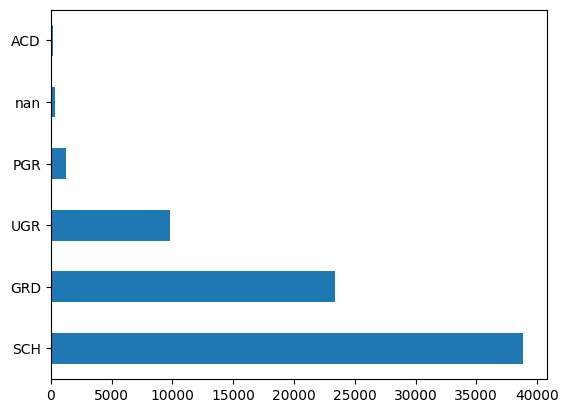

In [85]:
df['education'].value_counts(dropna = False).plot.barh()

Let's take a look on our observations with missing column values:

In [86]:
df[df['education'].isnull()]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
517,53844,03MAR2014,NaN,F,54,N,N,0,0,-2.781669,0,80,2,3,20000,1,4,Y,0
725,4918,11JAN2014,NaN,M,57,N,N,0,0,-2.186115,0,40,1,2,10000,1,4,N,0
1393,80738,28MAR2014,NaN,F,55,N,N,0,0,-2.062910,3,40,1,2,30000,1,4,N,0
1564,5925,13JAN2014,NaN,F,35,N,N,0,1,-2.023590,1,50,2,3,45000,1,3,N,1
1739,9175,16JAN2014,NaN,F,43,Y,N,0,0,-1.891956,0,50,2,3,9000,4,1,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72694,28025,04FEB2014,NaN,M,22,Y,N,0,0,-2.117309,1,70,2,3,22000,4,1,N,0
72705,100777,17APR2014,NaN,F,58,N,N,0,0,-2.267773,3,50,2,3,10000,4,1,N,0
72903,10917,18JAN2014,NaN,F,47,N,N,0,0,-2.214084,0,50,2,3,15000,1,4,N,0
73087,102635,20APR2014,NaN,F,56,N,N,0,0,-2.369820,6,80,2,3,12000,1,4,N,0


We shall replace the missing values with the modal category, in our case it is `SCH` education level.

In [87]:
df.education = df.education.fillna('SCH')

Let's use the 'pandas' library to preprocess the `app_date` variable for our analysis:

In [88]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
# Sequence of days sign
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')
df['app_date_month'] = df.app_date.dt.month

Let's check NaN's after replacing them in in the `education` column just in case.
We can see that we have no missing values in our data.
Finally, we can proceed working with the processed dataset.

In [89]:
df.isnull().sum() # check NaN's

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
days                0
app_date_month      0
dtype: int64

### Step 1.3: Descriptive statistics

For starters, let’s look at the statistical characteristics of the numerical variables

In [90]:
num_vars  = df.drop(columns=['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education', 'region_rating', 'work_address', 'sna', 'first_time', 'home_address', 'default','client_id','app_date'])
print("\nDescriptive statistics:")
num_vars.describe()


Descriptive statistics:


,age,decline_app_cnt,score_bki,bki_request_cnt,income,days,app_date_month
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,39.280641,0.275749,-1.904724,2.000339,41099.775417,61.035434,2.537053
std,11.520378,0.804272,0.498231,2.252073,46166.322400,32.121884,1.089098
min,21.000000,0.000000,-3.624586,0.000000,1000.000000,0.000000,1.000000
25%,30.000000,0.000000,-2.259534,0.000000,20000.000000,33.000000,2.000000
50%,37.000000,0.000000,-1.920823,1.000000,30000.000000,62.000000,3.000000
75%,48.000000,0.000000,-1.569831,3.000000,48000.000000,89.000000,3.000000
max,72.000000,33.000000,0.199773,53.000000,1000000.000000,119.000000,4.000000


In this step, we shall create a correlation matrix of quantitative variables using the heatmap from the `seaborn` library to visualize the correlation and easily determine the strength of the association between variables by color.
For evaluation the degree of dependence between ordinal and ranked quantitative varibles we use the Spearman rank correlation coefficient.
From our quantitative and ordinal data we can find highly correlated variables, but in our case we don't have any excess multicollinearity.
This means that we can continue to work with the data and use it in our models without any problem.

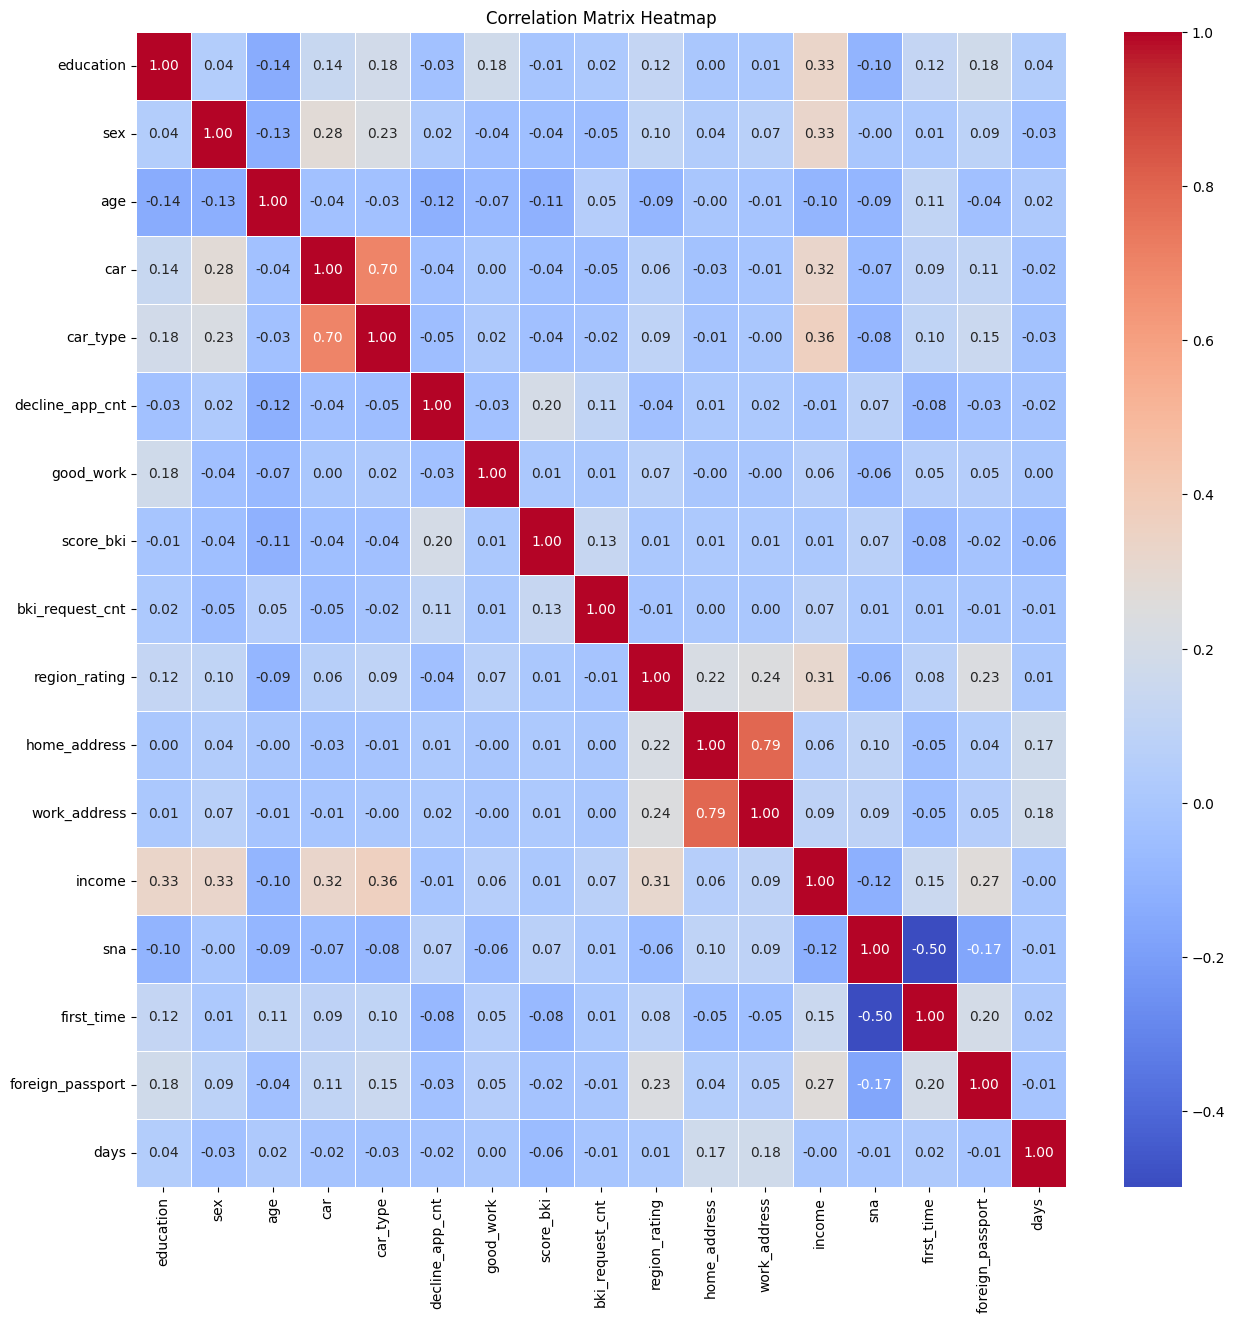

In [91]:

le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['car'] = le.fit_transform(df['car'])
df['car_type'] = le.fit_transform(df['car_type'])
df['foreign_passport'] = le.fit_transform(df['foreign_passport'])


# we could use the ordinal encoder, but we chose to manually assign the values to the categories
df['education'] = df['education'].replace("SCH", 1)
df['education'] = df['education'].replace("UGR", 2)
df['education'] = df['education'].replace("GRD", 3)
df['education'] = df['education'].replace("PGR", 4)
df['education'] = df['education'].replace("ACD", 5)


correlation_matrix = df.drop(columns = ['app_date_month', 'app_date','client_id', 'default']).corr(method='spearman')
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In this step, we shall split our variables into binary, quantitative and categorical variables.

In [92]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # default is target
cat_cols = ['education', 'region_rating', 'work_address',
            'sna', 'first_time', 'app_date_month']
quant_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'days']

So let's recode our categorical and binary variables into dummy variables.
And see that if we set the `drop_first` parameter to True, we will create one less variable than the number of categories.
This parameter setting prevents us from getting perfect multicollinearity of the regressors.

In [93]:
df_with_dummies = pd.get_dummies(df , columns = cat_cols, drop_first= True)
df_with_dummies = pd.get_dummies(df_with_dummies, columns = bin_cols,drop_first=True)

Now we visualize the relationships between pairs of variables in our dataset where each pair of variables is plotted against eachother, and diagonal elements show the distributions of individual variables:

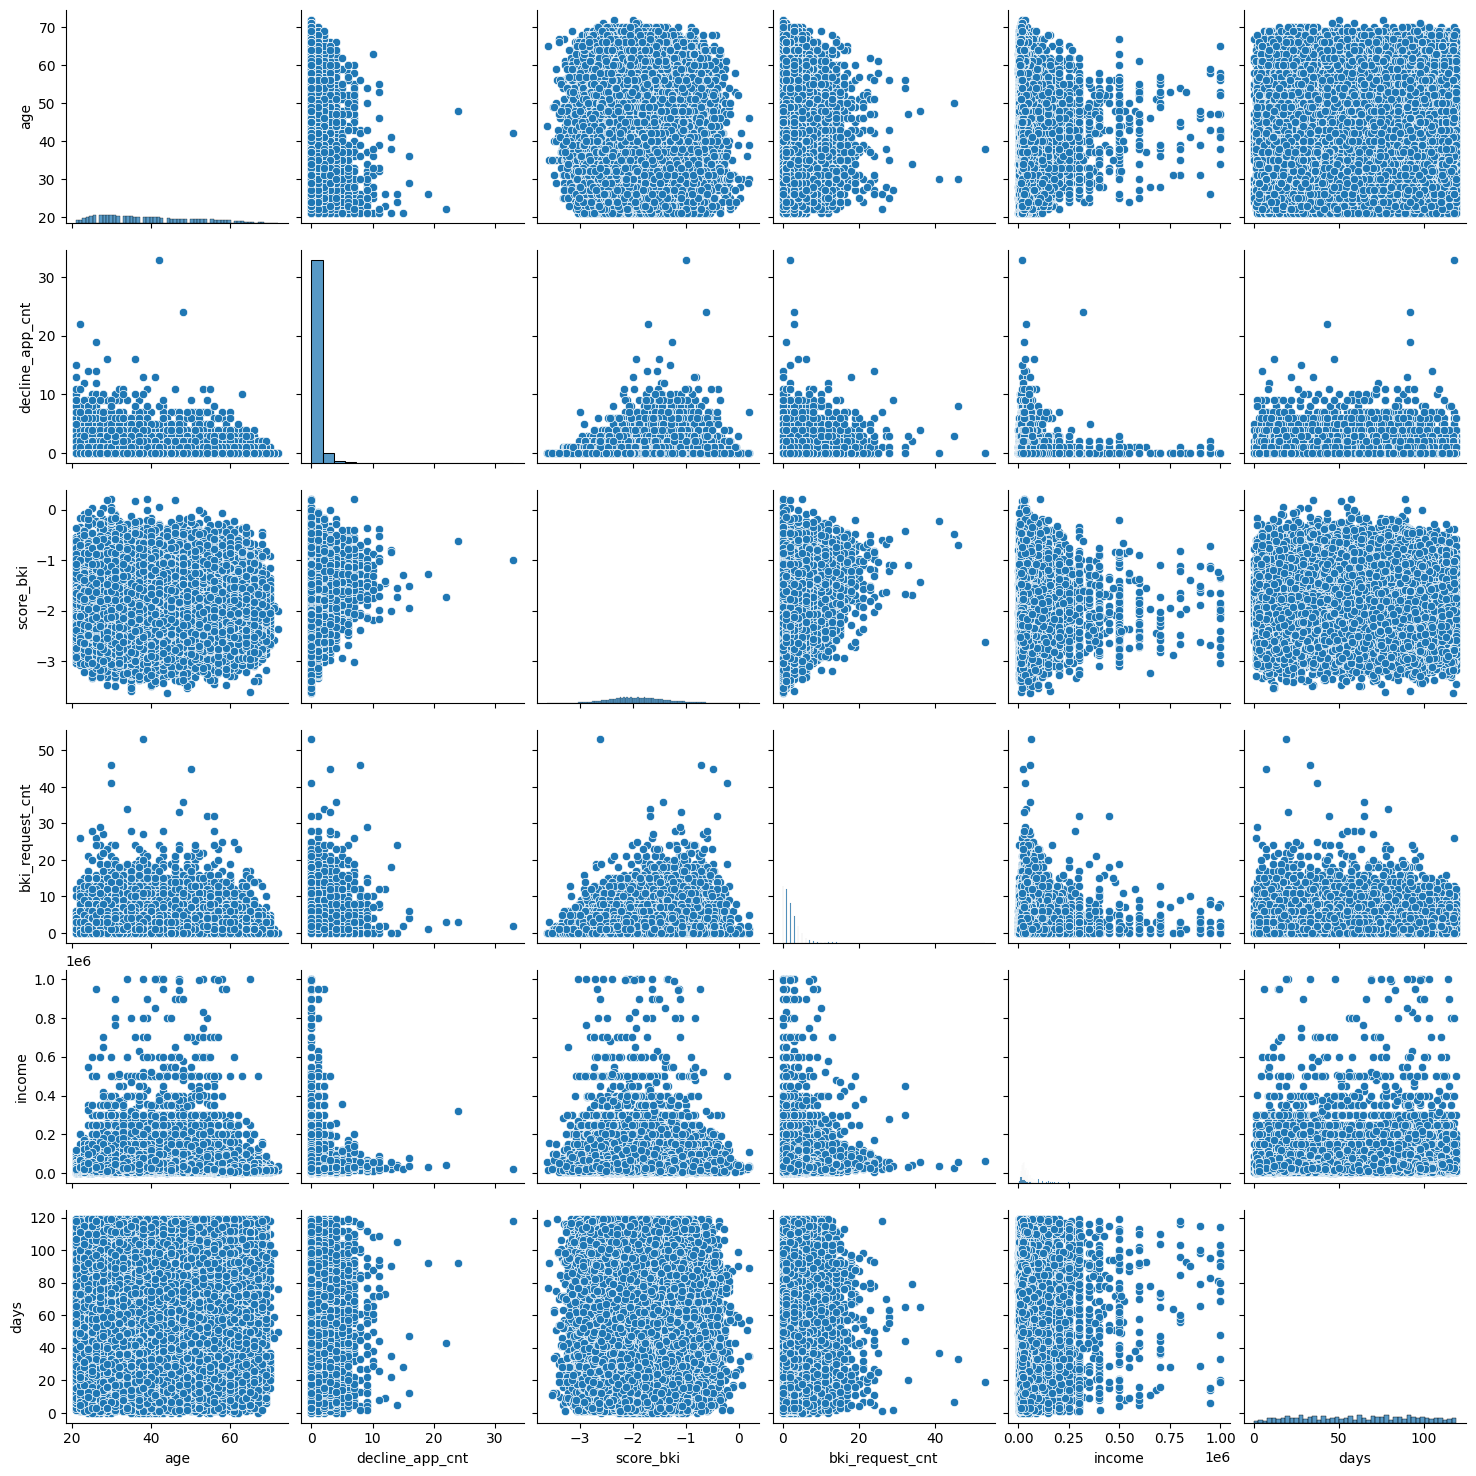

In [94]:
sns.pairplot(df[quant_cols])

Point-biseral correlation measures the strength of the  linear association between a quantitative and a binary variable.
We will now use this metric to perform feature selection of quantitative variables for usage in our models.

In [95]:
# create two lists, one for feature names and the second one for correlations
columns, correlations = [], []
 
# go through all columns of the dataframe except the target variable
for col in df[quant_cols].columns:
  # put the name of the variable in the list of columns
  columns.append(col)
  # calculate the correlation between this attribute and the target variable
  # and place the result in the list of correlations
  correlations.append(stats.pointbiserialr(df[col], df['default'])[0])
 
# create a dataframe based on the populated lists
# and apply a gradient colour scheme
pd.DataFrame({'column': columns, 'correlation': correlations}).style.background_gradient()

,column,correlation
0,age,-0.025004
1,decline_app_cnt,0.113682
2,score_bki,0.175369
3,bki_request_cnt,0.078242
4,income,-0.039752
5,days,-0.039372


As we can see from this table, the most correlated quantitative variables with the target are: `score_bki` (score according to data from the credit history bureau), `decline_app_cnt` (number of cancelled past loan applications) and `bki_request_cnt` (number of requests to the loan bureau).

In [96]:
label_encoder = LabelEncoder() # making an instance of Label Encoder
cat_bin_cols = cat_cols + bin_cols # recoding the categorical labels to numeric values
for col in cat_bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

Mutual information is a metric designed to measure the strength of nonlinear association between random variables.
We will now it to perform feature selection of categorical variables for future usage as default predictors.

In [97]:
mi = mutual_info_classif(df[cat_bin_cols], df['default'], discrete_features='auto')
mi = pd.Series(mi,index = cat_bin_cols)

Now we shall plot the mutual information between categorical, binary predictors and the target variable in descending order.

Text(0.5, 1.0, 'Mutual information between categorical, binary predictors and target')

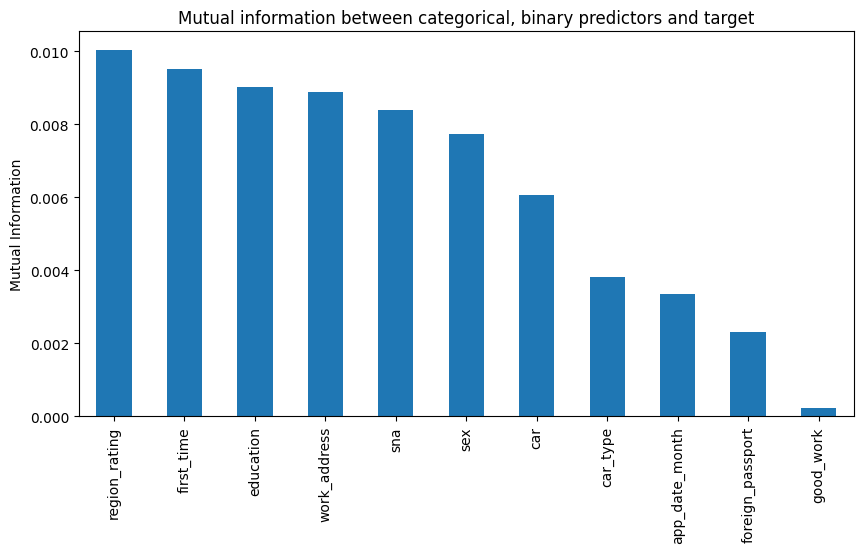

In [98]:
mi.index = cat_bin_cols
mi.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between categorical, binary predictors and target")

We can observe that every categorical variable adds new information to the dependent variable.
The biggest categorical predictors of the client being default/non-default seem to be `sex`, `first_time` (age of availability of information about the borrower), `work_address`, `sna` (borrower's relationship with the bank's clients), `region_rating`, and `education`.

We will also observe the plots of the probability of distribution of each numerical variable:

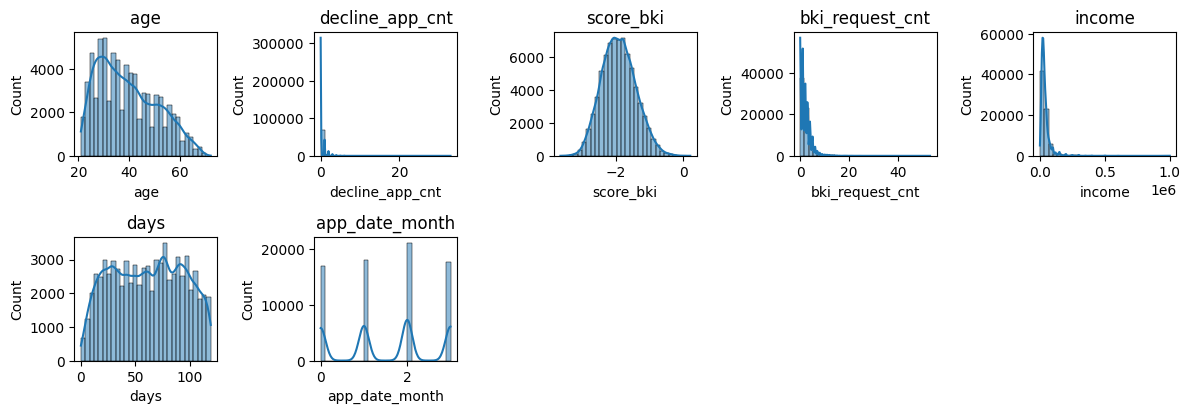

In [99]:
plt.figure(figsize=(12, 12))
for i, feature in enumerate(num_vars, 1):
    plt.subplot(6, 5, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout() 
plt.show()

In those variables, where the distribution is skewed to the right, we have decided to perform a logarithmic transformation to tailor to statistical assumptions of the regression analysis.
We should be careful, not to include the variables with non-positive values, including 0, as this may lead to infinitesimal values.
We did not remove outliers, as they could potentially convey addtitional information about non-typical clients.
Additionally, after repeated testing, we have concluded that they did not affect the performance of our models.

In [100]:
cols_to_log = ['age', # age distribution is log-normal, there are no outliers by quartiles. 
               'bki_request_cnt', # roughly log-normal, heavily skewed to the right
               'income'] # income distribution is log-normal, there are visible outliers
for col in cols_to_log:
    df[col] = df[col].apply(lambda x: np.log(x) + 1)

The target variable is unbalanced and we will deal with this problem by setting an optimal binary threshold later in the analysis.
We will not use oversampling, because we do not to artificially increase the minority class (defaulted clients) in our new sample.
We have decided against the usage of undersampling, beasue we would then lose the additional information about well-paying clients in our model. 

Distribution of target:
0    64427
1     9372
Name: default, dtype: int64


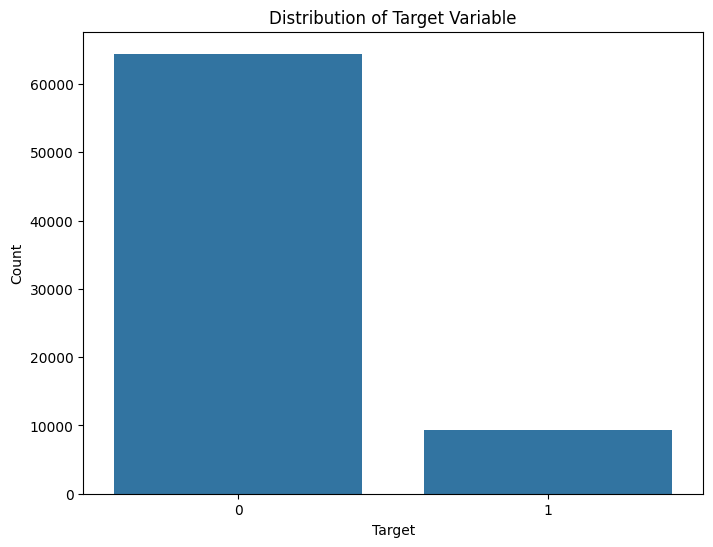

In [101]:
print("Distribution of target:", df['default'].value_counts(), sep='\n')

plt.figure(figsize=(8, 6))
sns.countplot(x='default', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In this step we perform the train-test split of our dataset and we additionally drop two columns: `client_id` and `app_date`.
We made a decision to delete them, because the `app_date` variable was strongly correlated with `days`. 
We also dropped `client_id` and `default`. 
The `client_id` variable is redundant and cannot be used as a predictor of `default`.
The `default` variable was dropped because it is the target variable, which we are trying to estimate using other variables.

In [102]:
data_train = df_with_dummies
data_train = data_train.drop(['client_id', 'app_date'], axis=1)
data_train = data_train[data_train['default'].notna()]
data_train.head()

,age,decline_app_cnt,score_bki,bki_request_cnt,home_address,income,default,days,education_2,education_3,...,first_time_3,first_time_4,app_date_month_2,app_date_month_3,app_date_month_4,sex_1,car_1,car_type_1,good_work_1,foreign_passport_1
0,62,0,-2.008753,1,1,18000,0,31,0,0,...,0,0,1,0,0,1,1,1,0,0
1,59,0,-1.532276,3,2,19000,0,70,0,0,...,0,0,0,1,0,0,0,0,0,0
2,25,2,-1.408142,1,1,30000,0,31,0,0,...,0,1,1,0,0,1,1,0,0,1
3,53,0,-2.057471,2,2,10000,0,22,0,0,...,1,0,0,0,0,0,0,0,0,0
4,48,0,-1.244723,1,2,30000,0,107,0,1,...,0,1,0,0,1,1,0,0,1,1


We shall check for the NaN's again, just to be sure.

In [103]:
X = data_train.drop(['default'], axis = 1)
Y = data_train['default']
data_train.isnull().sum()

age                   0
decline_app_cnt       0
score_bki             0
bki_request_cnt       0
home_address          0
income                0
default               0
days                  0
education_2           0
education_3           0
education_4           0
education_5           0
region_rating_30      0
region_rating_40      0
region_rating_50      0
region_rating_60      0
region_rating_70      0
region_rating_80      0
work_address_2        0
work_address_3        0
sna_2                 0
sna_3                 0
sna_4                 0
first_time_2          0
first_time_3          0
first_time_4          0
app_date_month_2      0
app_date_month_3      0
app_date_month_4      0
sex_1                 0
car_1                 0
car_type_1            0
good_work_1           0
foreign_passport_1    0
dtype: int64

In [104]:
data_train.shape

(73799, 34)

## Step 2: Logistic Regression

### Step 2.1: Splitting the dataset

In this part of the model buliding, we are going to divide our preprocessed dataset into training and test dataset.
As a result of dividing the dataset into training and test subsets, we can train the model on one part of the data and evaluate its performance on a different sample. 
This helps us evaluate how well the model generalizes to new data and prevents overfitting by providing an independent dataset for evaluation.

Importnant note: our decision to split the dataset at this stage and not before the preprocessing is due to the fact, that our steps before were mostly descriptive in nature and do not create bias in our data before the split.
The imputation of the modal category in the `education` variable conveys little to none skewness to the target variable predction, as the importance of that feature in mutual information is quite low.
The logarithmic transforamtion does not change the predictive value of the data.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 7)

Let's import the logistic regression implementation from `sklearn` and fit our model on the test data.

The most important parameters specified below are:

`C`: Determines the regularization strength

`penalty`: Specifies the norm used in penalization.

`solver`: Selects the optimization algorithm.

`class_weight`: Specifies class weights for imbalanced data.

In summary, this code sets up a logistic regression instance with specific settings tailored to the needs of the classification task, providing flexibility in terms of regularization, optimization, and handling of class imbalances.

### Step 2.2: Creation of a model

In [106]:
model = LogisticRegression(random_state = None,
                               C = 1,
                               dual = False,
                               fit_intercept = True,
                               intercept_scaling = 1,
                               l1_ratio = None,
                               max_iter = 100,
                               multi_class = 'auto',
                               n_jobs = None,
                               penalty = None,
                               solver = 'newton-cg',
                               tol = 0.0001,
                               verbose = 0,
                               warm_start = False,
                           class_weight = 'balanced')
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', penalty=None,
                   solver='newton-cg')

### Step 2.3: Assessment of modelling results

In this part of code we visualize the ROC curve of training data and find the optimal threshold.
From our coding result the optimal threshhold is the maximal difference between false positive and true positive rates.
After that we use `argmax()` function from  the `numpy` library that helps us find the index of the maximum difference.
Now we collect that as variable `optimal_idx_t`. 
Finally we just use the optimal threshhold index and find optimal `border` between the true and false predictions.

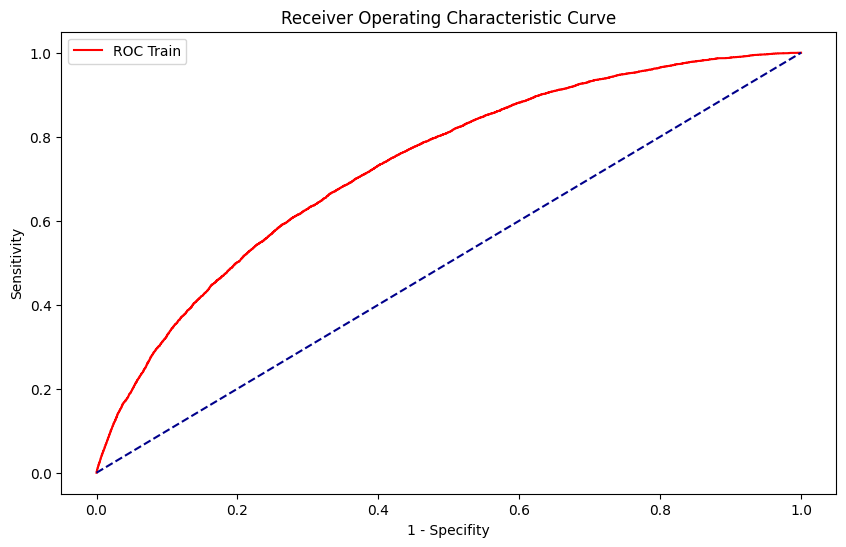

In [107]:
y_pred_log_t = model.predict_proba(X_train)



fpr_t, tpr_t, threshold_t = roc_curve(y_train, y_pred_log_t[:,1])

optimal_idx_t = np.argmax(tpr_t - fpr_t)

optimum_t = threshold_t[optimal_idx_t]

#Plotting the figure
plt.figure(figsize = (10,6))
plt.plot(fpr_t,tpr_t, color='red', label='ROC Train')
plt.plot([0, 1], [0, 1], color='darkblue' , linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()



After the moment when we have found our optimal threshold, we shall assign the values of our predictions to the train dataset.

It means that if the predicted probability of the `target` variable being 1 is bigger than the threshold, we will count that observation as a default of our client.

We shall visualize this using the confusion matrix.

We can see that in our model we are dealing with Type I. and II. errors.

For example, we can see that our logistic regression model assumes 15 081 clients have defaulted on their credit, when in reality they did not.

We can interpret this as a deviation of our model from the population or, simply, accuracy.

We can observe the analogous situation for defaulted clients. 

There are 2186 false positive predicitons in our model.

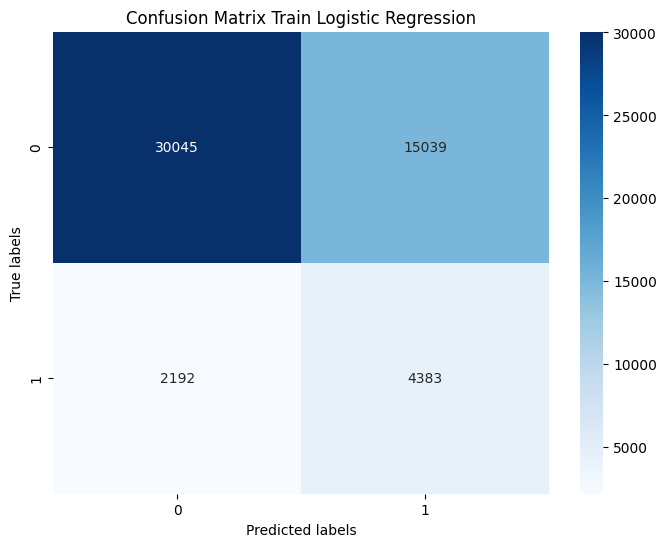

In [108]:
y_pred_actual_t = (y_pred_log_t[:,1]>optimum_t)

cm = confusion_matrix(y_train, y_pred_actual_t)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train Logistic Regression')
plt.show()

Now we can calculate the AUC score.
AUC it is area under the ROC curve.
We interpret this area as perfomance metric for our logistic regression and other models.

In [109]:
roc_auc_score(y_train, y_pred_log_t[:,1])

0.7310540054846499

We repeat the same algorithm to find the optimum threshold and visualize ROC curve for test dataset.
As we can see, the test and train ROC curves are almost identical.  

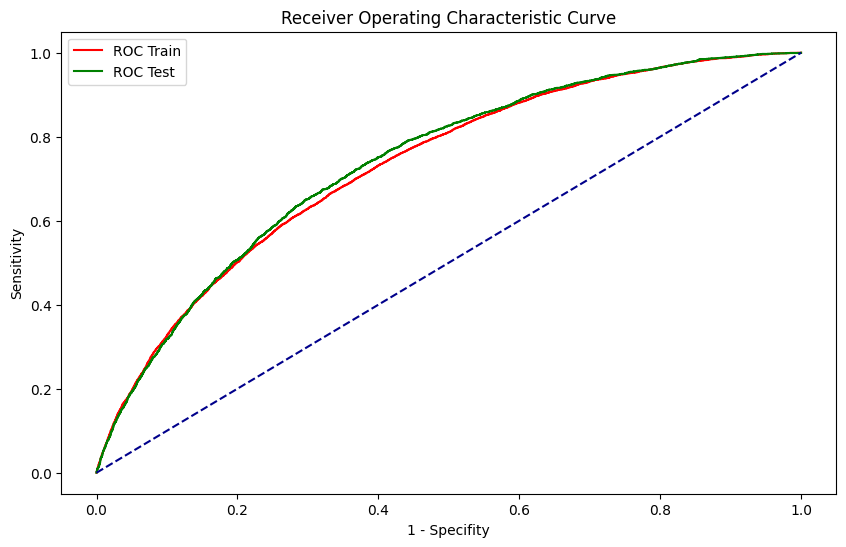

In [110]:
y_pred_log = model.predict_proba(X_test)



fpr, tpr, threshold = roc_curve(y_test, y_pred_log[:,1])

optimal_idx = np.argmax(tpr - fpr)

optimum = threshold[optimal_idx]



#Plotting the figure
plt.figure(figsize = (10,6))
plt.plot(fpr_t,tpr_t, color='red', label='ROC Train')
plt.plot(fpr,tpr, color='green', label='ROC Test')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

We again need to assign our new threshold value to split the predicted values into zeros and ones.

We visualize the confusion matrix using the `seaborn` library.

We can see that our result is almost as identically correct as a result on train data.

We can infer that the `train_test` split was done correctly and the model was well-trained without overfitting.  

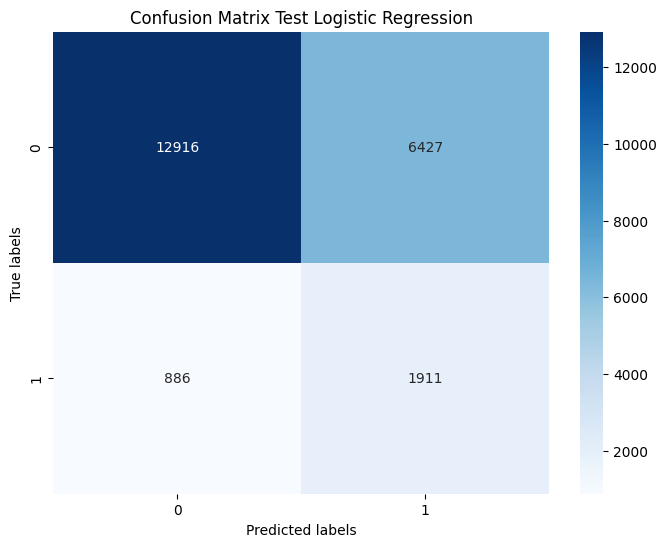

In [111]:
y_pred_actual = (y_pred_log[:,1]>optimum_t)

cm_t = confusion_matrix(y_test, y_pred_actual)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_t, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Logistic Regression')
plt.show()

We can now calculate the AUC score for the test data.

Is has improved by a tiny margin on newly tested data.

So we conclude that AUC for the test and train dataset is nearly equal.

In [112]:
roc_auc_score(y_test, y_pred_log[:,1])

0.7375174555658569

We additionally perform seven-fold cross-validation on our test dataset to ensure reproducibility using subsampling.
In principle, we divide our testing data into equal parts, and randomly assign roles to each one, so that every subsample has been used as a testing dataset.
In the end we calculate the mean score of the model under these conditions.

In [113]:
cv_vec_score = cross_val_score(model, X_test,y_test,scoring="roc_auc", cv = 7)

print(cv_vec_score.mean())

0.7362927628934427


## Step 3: Decision tree

### Step 3.1: Cross-validation

This code segment performs grid search cross-validation.
Its goal is to find the best hyperparameters for a decision tree classifier.
The alogrithm defines a parameter space with different values for criteria such as the split criterion, maximum depth, minimum samples for splitting, and maximum leaf nodes. 
Then, it conducts a grid search using these parameters, identifies the best configuration, and stores it in the variable `cls_params1`.

In [114]:
# setup parameter space
parameters = {'criterion':['gini'],
              'max_depth':np.arange(3,9).tolist()[0::2],
              'min_samples_split':np.arange(2,5).tolist()[0::2],
              'max_leaf_nodes':np.arange(20,27).tolist()[0::2]}

# create an instance of the grid search object
g1 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
g1.fit(X_train,y_train)

# show best parameter configuration found for classifier
cls_params1 = g1.best_params_
cls_params1

{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 26,
 'min_samples_split': 2}

### Step 3.2: Assessment of modelling results

Let's now take a look on ROC curve for our decision tree model on train data.
It will show the performance of the binary classifier for a different threshold.

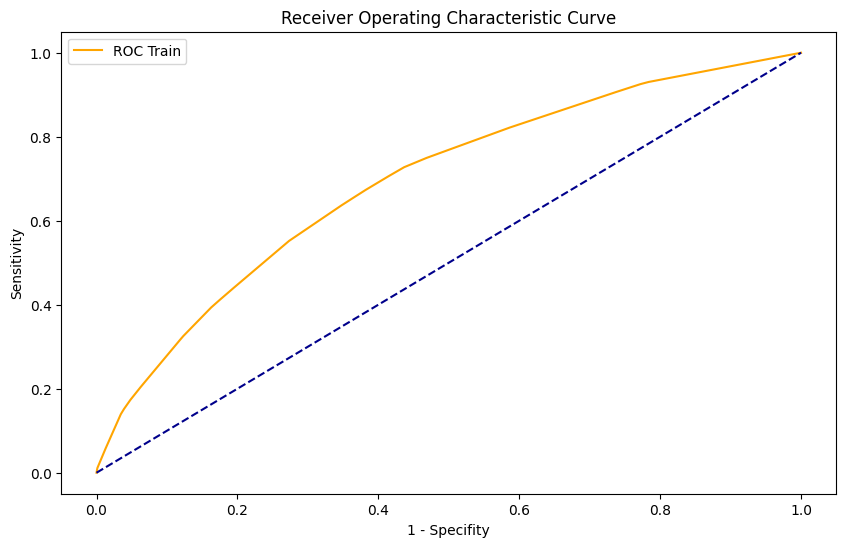

In [115]:
y_pred_ds = g1.predict_proba(X_train)

fpr_ds, tpr_ds, threshold_ds = roc_curve(y_train, y_pred_ds[:,1])
plt.figure(figsize = (10,6))
plt.plot(fpr_ds,tpr_ds, color='orange', label='ROC Train')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()





Let's compare our model for 'test' and 'train'. 
As we can observe our ROC curve is almost identical, which means that the model was estimated appropriately.

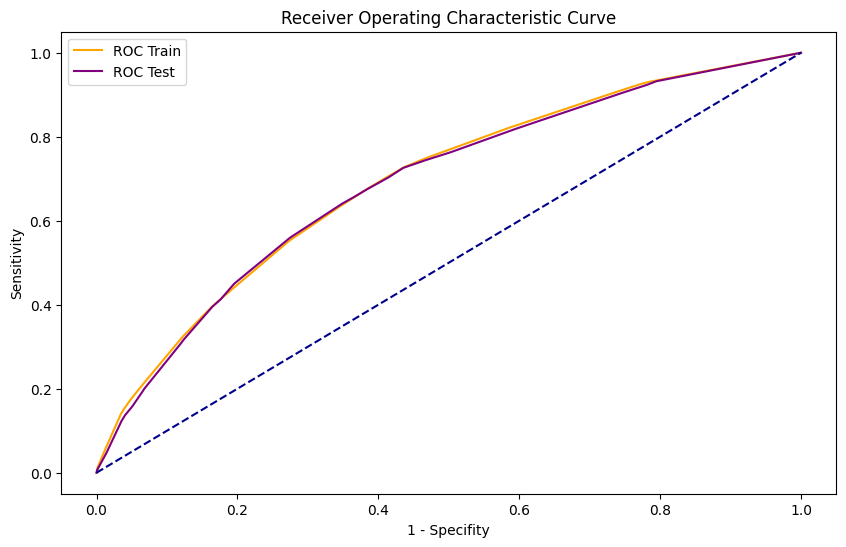

In [116]:
y_pred_ds_t = g1.predict_proba(X_test)

fpr_ds_t, tpr_ds_t, threshold_ds_t = roc_curve(y_test, y_pred_ds_t[:,1])
plt.figure(figsize = (10,6))
plt.plot(fpr_ds,tpr_ds, color='orange', label='ROC Train')
plt.plot(fpr_ds_t,tpr_ds_t, color='purple', label='ROC Test')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

We will now again find the optimal threshold.

The procedure is identical to the one in logistic regression and we will use that as cut-point for our model's decision making.

The next step is to plot the confusion matrix and to evaluate accuracy of our model.

As we can see we have correctly estimated 11 934 non-default cases and 1885 default cases, but we have wrongly determined 7 409 cases.

We have estimated them as default but in reality they were not default cases.

The same goes for the 912 cases that our model defines as default, but in truth those cases are non-default.

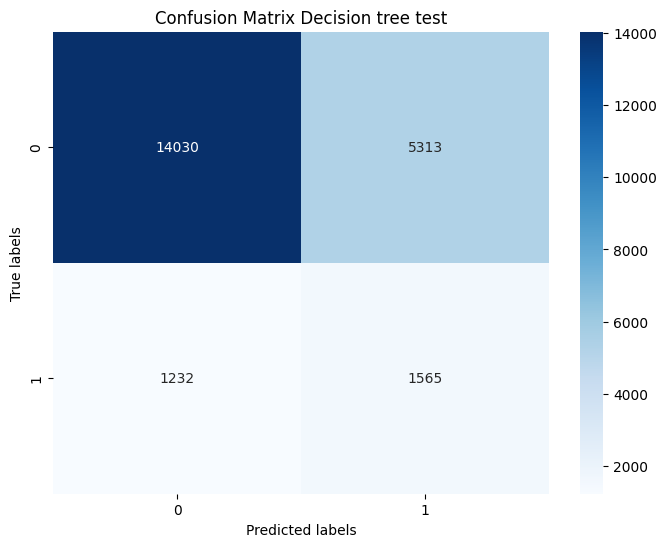

In [117]:
optimal_idx = np.argmax(tpr_ds_t - fpr_ds_t)

optimum_ds = threshold_ds_t[optimal_idx]

y_pred_actual_gg = (y_pred_ds_t[:,1]>optimum_ds)

cm_t = confusion_matrix(y_test, y_pred_actual_gg)
cm_ds = confusion_matrix(y_test, y_pred_actual_gg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ds, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Decision tree test')
plt.show()


We will now calcualte the AUC score for Decision Tree model on test data.
We can see that AUC a little bit smaller than the AUC for logistic regression.

In [118]:
roc_auc_score(y_test, y_pred_ds_t[:,1])

0.6891836403990502

## Step 4: XGboost

 This code defines an objective function for tuning parameters of an XGBoost model using the `optuna` library a hyperparameter optimization framework:

In [119]:

def objective(trial):
    '''Function to find best tuning params for XGboost'''
    # Copy test and trainsets
    X_train_ = X_train
    y_train_ = y_train
    valid_x = X_test
    valid_y = y_test
    dtrain = xgb.DMatrix(X_train_, label=y_train_)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    metric = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return metric

We create an `optuna` study object for hyperparameter optimization. We set its optimization direction to maximize the ROC AUC score.

The `study.optimize()` function specifies to run a maximum of 50 trials or until 600 seconds have passed, whichever comes first.

The function iterates different combinations of hyperparameters based on the objective function to find the optimal set of parameters that maximize the performance of the XGBoost model on the validation dataset.

In [120]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, timeout=600)

[I 2024-04-10 00:43:50,606] A new study created in memory with name: no-name-71bd7fde-eae5-4ff8-808a-5b3f7c26a9fd
[I 2024-04-10 00:43:50,950] Trial 0 finished with value: 0.5 and parameters: {'booster': 'gbtree', 'lambda': 0.00014364699639559883, 'alpha': 1.748806070139441e-08, 'subsample': 0.8996044737855418, 'colsample_bytree': 0.3027946126297999, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.10452521713871873, 'gamma': 0.025176001867006883, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5.
[I 2024-04-10 00:43:51,403] Trial 1 finished with value: 0.5 and parameters: {'booster': 'dart', 'lambda': 1.407618365211087e-07, 'alpha': 9.487036501372284e-06, 'subsample': 0.34767014724866274, 'colsample_bytree': 0.4726033261551435, 'max_depth': 3, 'min_child_weight': 9, 'eta': 4.593944487993995e-08, 'gamma': 0.1070037339161044, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.001719024369998489, 'skip_drop': 0.2353078706618733}. Be

After the hyperparameter optimization process completes the code, extracts the best parameters found during the optimization and assigns them to the variable `param_xb` . These best parameters are obtained from the study object using the best_params attribute.

This step is important as it captures the hyperparameters that resulted in the highest evaluation metric, the ROC-AUC score These optimized parameters can then be used to train the final XGBoost model for deployment or further evaluation on test data.


In [121]:
param_xb = study.best_params
param_xb

{'booster': 'gbtree',
 'lambda': 1.4887161009569213e-06,
 'alpha': 0.016685593116787936,
 'subsample': 0.29078070155527175,
 'colsample_bytree': 0.502518729619391,
 'max_depth': 5,
 'min_child_weight': 8,
 'eta': 0.8309603971863982,
 'gamma': 0.7064549806721567,
 'grow_policy': 'depthwise'}

We now utilize the XGBoost classifier from the XGBoost library to create a model instance with the parameters obtained from the previous step.

Subsequently, the classifier is trained on the training data (X_train and y_train) using the `fit()` method.

Our model tries to minimize the difference between actual and predicted labels.

Finally, the trained classifier is used to predict labels for the test dataset (X_test).

The predicted labels are stored in the variable `y_pred_xb`.

These predicted labels can then be evaluated against the true labels to assess the model's performance.

In [122]:
clf_xb = xgb.XGBClassifier(param = param_xb)

clf_xb.fit(X_train,y_train)


y_pred_xb = clf_xb.predict(X_test)

The code segment below computes the predicted probabilities of the test data using the trained XGBoost classifier.

These predicted probabilities are then used to compute the Receiver Operating Characteristic (ROC) curve and the corresponding thresholds (`threshold_xgb_t`) using the true labels .

The code identifies the optimal threshold by maximizing the difference between the true positive rate and the false positive rate using the roc_curve instatnce.

After determining the optimal threshold, the code applies it to the predicted probabilities to obtain the actual predicted labels.

This is done by comparing each probability to the threshold and classifying instances as positive or negative based on whether their predicted probability exceeds the threshold.

We then make binary predictions based on the XGBoost classifier's predicted probabilities.

Now we shall perform the same procedure of plotting the ROC curve of test and train data.
We can observe next to zero deviation of prediction success of independent data.
This is an indication of the absence of overfitting in our model.

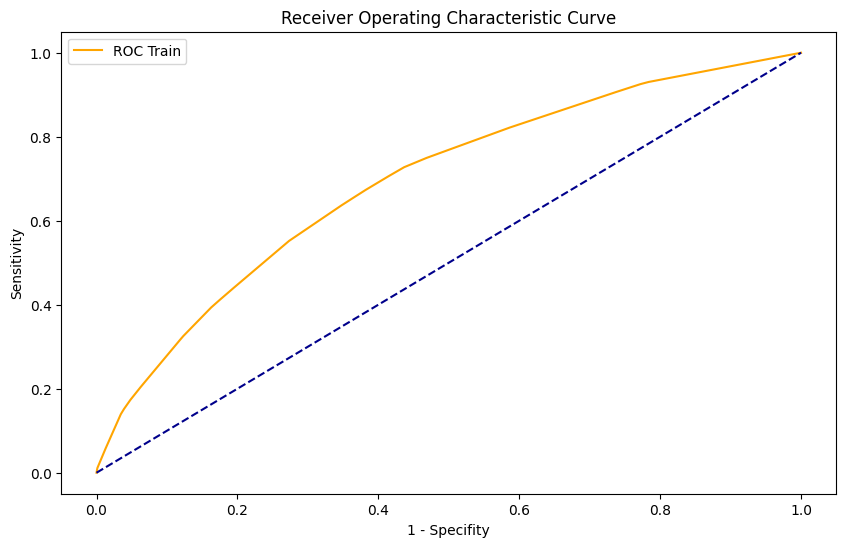

In [123]:
y_pred_xgb = clf_xb.predict_proba(X_train)

fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_train, y_pred_xgb[:,1])
plt.figure(figsize = (10,6))
plt.plot(fpr_ds,tpr_ds, color='orange', label='ROC Train')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

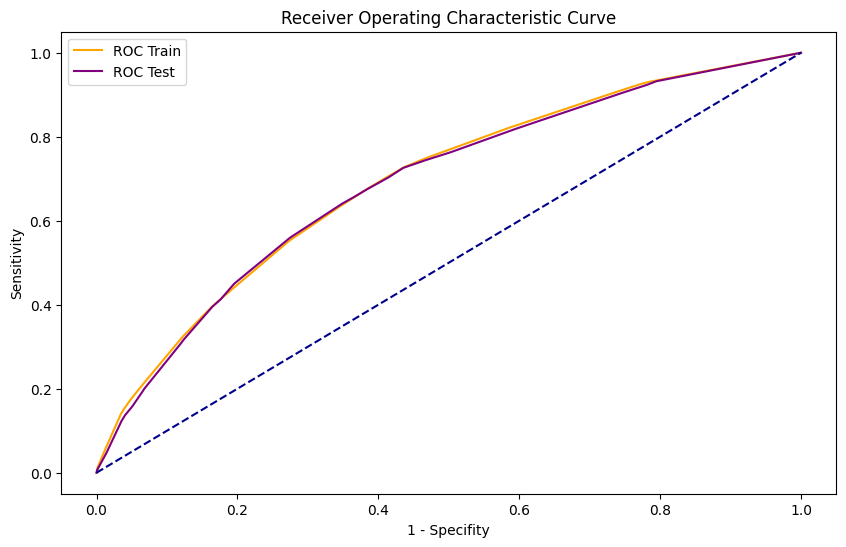

In [124]:
y_pred_xgb_t = clf_xb.predict_proba(X_test)

fpr_xgb_t, tpr_xgb_t, threshold_xgb_t = roc_curve(y_test, y_pred_xgb_t[:,1])

plt.figure(figsize = (10,6))
plt.plot(fpr_ds,tpr_ds, color='orange', label='ROC Train')
plt.plot(fpr_ds_t,tpr_ds_t, color='purple', label='ROC Test')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [125]:
optimal_idx_xgb = np.argmax(tpr_xgb_t - fpr_xgb_t)

optimum_ds_xgb = threshold_xgb_t[optimal_idx_xgb]

y_pred_actual_gg = (y_pred_xgb_t[:,1]>optimum_ds_xgb)
cf_matrix = confusion_matrix(y_test, y_pred_actual_gg)


Our confusion matrix is roughly the same as in the other two models.

The trained model does not overfit and we can correctly predict approximately two-thirds of defaults and two-thirds of successfull repayments by clients.

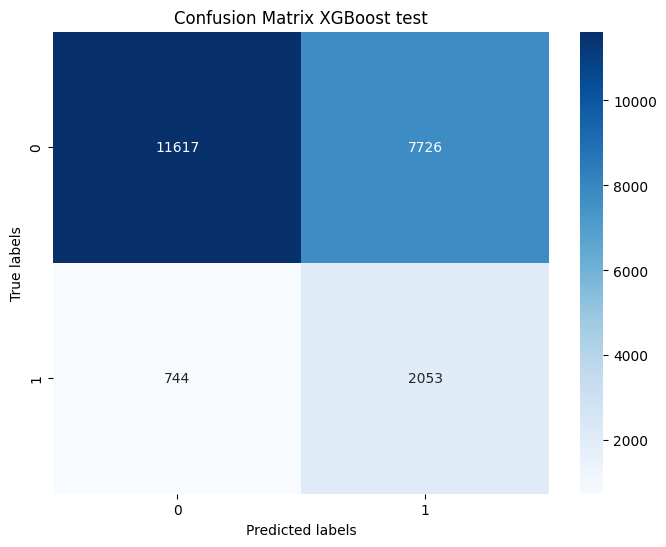

In [126]:
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XGBoost test')
plt.show()

In [127]:
roc_auc_score(y_test,y_pred_xgb_t[:,1]) # the auc score is comparable to logistic regression

0.7212513200207066

In conclusion, we state that the models are comparable in their prediciton capabilities.

We prefer the logistic regression model, as it gives room for interpretaion using the odds-ratio-to-regressor change.